In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
!pip install -U bitsandbytes


In [ ]:
from huggingface_hub import login
login()  # Paste your token when prompted


In [ ]:
!pip install -q transformers accelerate bitsandbytes scikit-learn pandas matplotlib tqdm sacrebleu rouge-score


# Import Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from tqdm import tqdm
from google.colab import drive
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sacrebleu.metrics import BLEU
from rouge_score import rouge_scorer

model_name = "mistralai/Mistral-7B-Instruct-v0.1"

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Load model using quantization with automatic device mapping and offloading
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # ✅ this is the correct way
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    offload_folder="/content/drive/MyDrive/offload",  # Path for offloaded layers
    offload_state_dict=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Mounted at /content/drive


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


 Classification Report ( Prompt - Tuned -1):
              precision    recall  f1-score   support

        true       0.95      0.35      0.51        54
       false       0.92      0.38      0.53        32
  misleading       0.21      1.00      0.35        14

    accuracy                           0.45       100
   macro avg       0.69      0.58      0.46       100
weighted avg       0.84      0.45      0.50       100
 



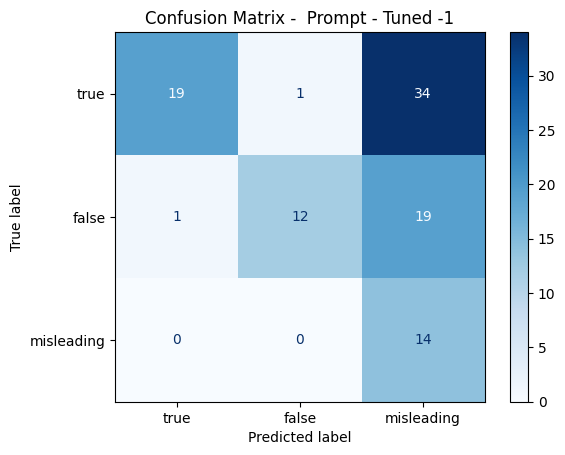


Benchmarking Summary Table:



,Metric,Your Model Value,Best Value,Good Value
0,Accuracy,0.45,100%,80–95%+
1,Precision,0.69,100%,80–90%+
2,Recall,0.58,100%,80–90%+
3,F1 Score,0.46,100%,80–90%+
4,False Positive Rate,0.65,0%,<5%
5,Trustworthiness Score,0.35,100%,85–95%+


BLEU Score: 0.0
ROUGE-L Score: 0.45


In [ ]:
def load_data_from_file():
    # Mount Google Drive and Load Dataset
    drive.mount('/content/drive')
    df = pd.read_json("/content/drive/MyDrive/HealthFacts/HealthFact_sample.json", lines=True)

    #Preparing dataset
    df = df.dropna(subset=["claim", "explanation", "label"])
    df["label"] = df["label"].astype(str).str.lower().str.strip()
    df = df.head(100)
    return df

def load_sample_prompt():
    sample_prompt = [
    {"claim": "Drinking hot water kills the coronavirus.", "explanation": "Hot water does not reach internal tissues where the virus replicates.", "label": "false"},
    {"claim": "Vaccines contain microchips for tracking.", "explanation": "No scientific evidence supports the presence of microchips in vaccines.", "label": "false"},
    {"claim": "COVID-19 vaccines cause infertility in women.", "explanation": "Studies show no link between COVID-19 vaccines and infertility.", "label": "misleading"},
    {"claim": "Garlic helps reduce blood pressure.", "explanation": "Garlic may help lower blood pressure, supported by some studies.", "label": "true"},
    {"claim": "Antibiotics cure viral infections.", "explanation": "Antibiotics target bacteria, not viruses.", "label": "false"},
    {"claim": "Aspirin may help prevent heart attacks in some people.", "explanation": "Low-dose aspirin reduces clotting risk in heart patients.", "label": "true"},
    {"claim": "Wearing a mask reduces the spread of airborne viruses.", "explanation": "Masks reduce virus-laden droplets.", "label": "true"},
    {"claim": "Sun exposure cures depression.", "explanation": "Sunlight helps mood but is not a clinical cure.", "label": "misleading"},
    {"claim": "Paracetamol lowers body temperature during fever.", "explanation": "Paracetamol is used to reduce fever and pain.", "label": "true"},
    {"claim": "Green tea cures cancer.", "explanation": "No evidence proves green tea cures cancer.", "label": "misleading"},
    {"claim": "Natural immunity is always better than vaccine immunity.", "explanation": "Natural immunity can be risky; vaccines are safer.", "label": "misleading"},
    {"claim": "Misinformation spreads faster than scientific facts online.", "explanation": "False claims spread more rapidly than verified facts.", "label": "true"},
    {"claim": "COVID-19 is no worse than the flu.", "explanation": "COVID-19 has higher mortality and transmission.", "label": "false"},
    {"claim": "5G networks cause cancer.", "explanation": "No evidence links 5G to cancer.", "label": "false"},
    {"claim": "Eating carrots improves night vision.", "explanation": "Vitamin A helps vision but doesn't give superpowers.", "label": "misleading"},
    {"claim": "COVID-19 vaccines alter human DNA.", "explanation": "mRNA vaccines do not change DNA.", "label": "false"},
    {"claim": "Honey helps soothe sore throats.", "explanation": "Honey has antibacterial and soothing properties.", "label": "true"},
    {"claim": "Boiled turmeric water cures diabetes.", "explanation": "Turmeric may help but is not a cure.", "label": "misleading"},
    {"claim": "Pregnant women should avoid all vaccines.", "explanation": "Many vaccines are safe and protective in pregnancy.", "label": "false"},
    {"claim": "Regular exercise improves mental health.", "explanation": "Exercise boosts endorphins and reduces anxiety.", "label": "true"}
    ]
    df = pd.DataFrame(sample_prompt);
    return df;




# Generate Basic Prompt and engineered prompt

def basic_prompt(claim, explanation):
    return (
        f"Claim: {claim}\n"
        f"Explanation: {explanation}\n"
        "Is this claim true, false, or misleading?\nAnswer:"
    )

def engineered_prompt(claim, explanation):
    return (
        f"[INST] <<SYS>>\n"
        f"You are a critical, evidence-based medical fact-checking assistant. Your job is to rigorously evaluate the **accuracy of medical claims** using provided evidence only. "
        f"Never assume information that is not explicitly given. "
        f"Return only one label: true, false, or misleading.\n<</SYS>>\n"
        f"Evaluate the following:\n"
        f"Claim: {claim}\n"
        f"Evidence: {explanation}\n\n"
        f"Is the claim supported by the evidence?\n"
        f"Respond with one word only (true, false, or misleading).\n[/INST]"
    )

# Model Input Function
def input_model(prompt, max_new_tokens=64, temperature=0.7, top_p=0.9, repetition_penalty=1.1):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            top_p=top_p,
            temperature=temperature,
            repetition_penalty=repetition_penalty

        )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).lower()
    last_token = generated_text.split()[-1].strip(".,!?")

    # Match labels
    if last_token in ["true", "false", "misleading"]:
        return last_token
    else:
        return "unknown"


# Benchmarking function
def run_benchmark(df,  prompt_func, model_func):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        prompt = prompt_func(row["claim"], row["explanation"])
        prediction = model_func(prompt)
        results.append({
            "claim": row["claim"],
            "actual": row["label"],
            "predicted": prediction
        })
    return pd.DataFrame(results)

def evaluation_metrics(results_df):

    #Accuracy in misinformation classification, False Positive Rate, Trustworthiness Score
    # Ensure all labels are strings
    results_df["actual"] = results_df["actual"].astype(str).str.lower().str.strip()
    results_df["predicted"] = results_df["predicted"].astype(str).str.lower().str.strip()

    accuracy = (results_df["actual"] == results_df["predicted"]).mean()

    #False Positive Rate for "true"
    actual_true = (results_df["actual"] == "true")
    total_true = actual_true.sum()

    if total_true > 0:
        wrong_prediction = (actual_true & (results_df["predicted"] != "true")).sum()
        fpr = wrong_prediction / total_true
    else:
        fpr = 0.0  # exceptional case

    #Trustworthiness Score (recall for the class true)
    if total_true > 0:
        correct_true = (actual_true & (results_df["predicted"] == "true")).sum()
        trustworthiness_score = correct_true / total_true
    else:
        trustworthiness_score = 0.0

    return accuracy, fpr, trustworthiness_score

def evaluate_results(results_df, title="Evaluation"):
    labels = ["true", "false", "misleading"]

    # Handle non string data
    results_df["actual"] = results_df["actual"].astype(str).str.lower().str.strip()
    results_df["predicted"] = results_df["predicted"].astype(str).str.lower().str.strip()

    filtered_df = results_df[results_df["predicted"] != "unknown"]
    y_true = filtered_df["actual"]
    y_pred = filtered_df["predicted"]

    print(f"\n Classification Report ({title}):")
    print(f"{classification_report(y_true, y_pred, labels=labels)} \n")

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

     # Evaluation metrics
    accuracy, fpr, trustworthiness = evaluation_metrics(results_df)

    from sklearn.metrics import precision_score, recall_score, f1_score

    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    generate_summary_table(accuracy, precision, recall, f1, fpr, trustworthiness)
    #BLEU Score ROUGE-L Score
    bleu, rouge = compute_bleu_rouge(results_df)
    print("BLEU Score:", bleu)
    print("ROUGE-L Score:", rouge)




def compute_bleu_rouge(results_df):
    predictions = results_df["predicted"].astype(str).tolist()
    references = results_df["actual"].astype(str).tolist()

    # BLEU Score
    bleu = BLEU()
    bleu_score = bleu.corpus_score(predictions, [references]).score

    # ROUGE-L Score
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(ref, pred)["rougeL"].fmeasure for ref, pred in zip(references, predictions)]
    avg_rougeL = sum(rouge_scores) / len(rouge_scores) if rouge_scores else 0.0

    return bleu_score, avg_rougeL


def generate_summary_table(accuracy, precision, recall, f1, fpr, trustworthiness):
    data = {
        "Metric": ["Accuracy","Precision","Recall","F1 Score","False Positive Rate","Trustworthiness Score"],
        "Your Model Value": [round(accuracy, 2),round(precision, 2),round(recall, 2), round(f1, 2),round(fpr, 2),round(trustworthiness, 2)],
        "Best Value": ["100%", "100%", "100%", "100%", "0%", "100%"],
        "Good Value": ["80–95%+", "80–90%+", "80–90%+", "80–90%+", "<5%", "85–95%+"]
    }

    df_summary = pd.DataFrame(data)
    print("\nBenchmarking Summary Table:\n")
    display(df_summary)


#load data
df = load_data_from_file()
#df = load_sample_prompt()


# Run benchmarks
#results_basic = run_benchmark(df, basic_prompt)
#results_engineered = run_benchmark(df, engineered_prompt)

# Evaluate
#evaluate_results(results_basic, title="Basic Prompt")
#evaluate_results(results_engineered, title="Engineered Prompt")
promt_to_test = engineered_prompt

results_tuned = run_benchmark(
    df,
    lambda c, e: promt_to_test(c, e),
    lambda p: input_model(p, max_new_tokens=64, temperature=0.7, top_p=0.9)
)

evaluate_results(results_tuned, title=" Prompt - Tuned -1")

#
#results_tuned = run_benchmark(
#    df,
 #   lambda c, e: promt_to_test(c, e),
#    lambda p: input_model(p, max_new_tokens=32, temperature=0.3, top_p=0.9)
##)
#evaluate_results(results_tuned, title=" Prompt - Tuned -2")

#results_tuned = run_benchmark(
#    df,
#    lambda c, e: promt_to_test(c, e),
 #   lambda p: input_model(p, max_new_tokens=128, temperature=0.5, top_p=0.9)
#)
#evaluate_results(results_tuned, title=" Prompt - Tuned -2")




